<a href="https://colab.research.google.com/github/vikram4690/YANA/blob/main/YANA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install modules
!pip install langchain langchain-community chromadb gradio pymupdf python-docx ollama langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.8 MB/s eta 0:0

In [2]:
!pip install newspaper3k lxml-html-clean

  Using cached newspaper3k-0.2.8-py3-none-any.whl.metadata (11 kB)
  Using cached lxml_html_clean-0.4.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached cssselect-1.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached tldextract-5.1.3-py3-none-any.whl.metadata (11 kB)
  Using cached feedfinder2-0.0.4.tar.gz (3.3 kB)
  Preparing metadata (setup.py) ... done
  Using cached jieba3k-0.35.1.zip (7.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached tinysegmenter-0.3.tar.gz (16 kB)
  Preparing metadata (setup.py) ... done
  Using cached sgmllib3k-1.0.0.tar.gz (5.8 kB)
  Preparing metadata (setup.py) ... done
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached newspaper3k-0.2.8-py3-none-any.whl (211 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 8.3 MB/s eta 0:00:00
  Created wheel f

In [10]:
import os

from datetime import datetime
import pandas as pd
from tqdm.notebook import tqdm

import newspaper
from newspaper import Config


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

from transformers import pipeline

from PIL import Image, ImageFont, ImageDraw
import textwrap

import warnings

from google.colab import drive

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import Ollama
import pprint
from IPython import embed

In [11]:
warnings.filterwarnings('ignore')

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
nltk.download('punkt_tab', quiet=True)

True

In [35]:
# Download necessary NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)

stop_words = set(nltk.corpus.stopwords.words('english'))

# Configuration
config = Config()
config.request_timeout = 10 # Increase timeout to 15 seconds (or more)

BASE_PATH = '/content/YANA'
ENV = 'dev'

URL_LIST = ['https://timesofindia.indiatimes.com']
URL_LIST1 = ['https://www.indiatoday.in/', 'https://www.indiatoday.in/', 'https://timesofindia.indiatimes.com', 'https://www.financialexpress.com', 'https://www.businesstoday.in', 'https://www.bbc.com/news/world/asia/india', 'https://edition.cnn.com/', 'https://www.beinsports.com/en-mena/all-news']

# Directory Setup (once)
CURRENT_DATE = datetime.now().date()
DIRECTORIES = {
    'sourced_news': os.path.join(BASE_PATH, ENV, 'sourced_news', str(CURRENT_DATE)),
    'cleaned_news': os.path.join(BASE_PATH, ENV, 'cleaned_news', str(CURRENT_DATE)),
    'images': os.path.join(BASE_PATH, ENV, 'images', str(CURRENT_DATE)),
}

for path in DIRECTORIES.values():
    os.makedirs(path, exist_ok=True)
    print(f"Directory created: {path}")

print('newspaper hot news: ', newspaper.hot())



# Pull news articles
for index, link in tqdm(enumerate(URL_LIST), desc='Reading news sites'):
    print(f"Website No: {index}, Url: {link}")
    news = []
    paper = newspaper.build(link,
                            language='en',
                            memoize_articles=False,
                            fetch_images=True,
                            threads=5,
                            config=config)
    print('paper size: ', paper.size())

    for category_urls in tqdm(paper.category_urls(), desc="Scraping News Categories"):
        print('category_urls: ' + category_urls)
        url = newspaper.build(category_urls,
                              language='en',
                              memoize_articles=False,
                              fetch_images=True,
                              threads=5,
                              config=config)

        article_count = 0
        for article in tqdm(paper.articles, desc="Pulling Articles"):
            article.download()
            article.parse()
            article.nlp()
            #print(article.url)
            if article.text and article.publish_date and article.publish_date.date() == CURRENT_DATE and article.url:  # Check if article.text is not empty
                #print("---", article_count)
                #print("---", article_count, f"Publish Date: {article.publish_date}, URL: {article.url}")
                #print(f"Title: {article.title}")
                #print(f"Text: {article.text[:200]}...")  # Print a snippet of the text
                news.append(link + "~|~" + article.url + "~|~" + article.title + "~|~" + str(article.publish_date) + "~|~" + article.summary + "~|~" + str(article.keywords) + "~|~" + article.text)

                print(article.top_image)
                data = [row.split("~|~") for row in news]
                df = pd.DataFrame(data)
                df.columns = ["source", "link", "title", "publish_date", "summary", "keywords", "desc"]
                df.to_csv(f'{BASE_PATH}/{ENV}/sourced_news/{CURRENT_DATE}/news_articles.csv', index=False)

                # pull-images
                img_url = article.top_image
                urllib.request.urlretrieve(img_url, f'{BASE_PATH}/{ENV}/images/{CURRENT_DATE}/{article.title}.jpg')

                article_count+=1

            if article_count>=5:  # Stop after 10 articles
                break

    print("News articles written to: ", f'{BASE_PATH}/{ENV}/sourced_news/{CURRENT_DATE}/news_articles.csv')

Directory created: /content/YANA/dev/sourced_news/2025-02-18
Directory created: /content/YANA/dev/cleaned_news/2025-02-18
Directory created: /content/YANA/dev/images/2025-02-18
newspaper hot news:  ['Delta plane crash', 'Paquita la del Barrio', 'Barcelona', 'All-Star Game', 'Usa hockey', 'Duke basketball', 'Ryan Reynolds', 'Lil Wayne', 'Pope Francis', 'Grok 3', 'Aubrey Plaza husband', 'Brian Laundrie', 'George Washington', '4 Nations', 'FAA', 'Paquita del Barrio', 'State Department Taiwan independence', 'Karl-Anthony Towns', 'Sabrina Carpenter', 'White Lotus Season 3']


Reading news sites: 0it [00:00, ?it/s]

Website No: 0, Url: https://timesofindia.indiatimes.com


CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/rss
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feeds


paper size:  246


Scraping News Categories:   0%|          | 0/8 [00:00<?, ?it/s]

category_urls: https://gadgetsnow.indiatimes.com


CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://gadgetsnow.indiatimes.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://gadgetsnow.indiatimes.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://gadgetsnow.indiatimes.com/rss


Pulling Articles:   0%|          | 0/246 [00:00<?, ?it/s]

https://im.indiatimes.in/content/2025/Feb/j-hope-hope-on-the-street-vol1_capa-1_widelg-1_67b36e2de9f77.jpg
https://im.indiatimes.in/content/template/share/652975.jpg
https://im.indiatimes.in/content/template/share/652994.jpg
https://im.indiatimes.in/content/template/share/652976.jpg
https://im.indiatimes.in/content/template/share/652970.jpg
category_urls: https://timesofindia.indiatimes.com


CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/rss


Pulling Articles:   0%|          | 0/246 [00:00<?, ?it/s]

https://im.indiatimes.in/content/2025/Feb/j-hope-hope-on-the-street-vol1_capa-1_widelg-1_67b36e2de9f77.jpg
https://im.indiatimes.in/content/template/share/652975.jpg
https://im.indiatimes.in/content/template/share/652994.jpg
https://im.indiatimes.in/content/template/share/652976.jpg
https://im.indiatimes.in/content/template/share/652970.jpg
category_urls: http://timesofindia.indiatimes.com


CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/rss
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feeds


Pulling Articles:   0%|          | 0/246 [00:00<?, ?it/s]

https://im.indiatimes.in/content/2025/Feb/j-hope-hope-on-the-street-vol1_capa-1_widelg-1_67b36e2de9f77.jpg
https://im.indiatimes.in/content/template/share/652975.jpg
https://im.indiatimes.in/content/template/share/652994.jpg
https://im.indiatimes.in/content/template/share/652976.jpg
https://im.indiatimes.in/content/template/share/652970.jpg
category_urls: https://timesofindia.indiatimes.com


CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feeds
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/feed
CRITICAL:newspaper.network:[REQUEST FAILED] 404 Client Error: Not Found for url: https://timesofindia.indiatimes.com/rss


Pulling Articles:   0%|          | 0/246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [132]:
### Clean the news

# Read today's collected news
directory_path = f'{BASE_PATH}/{ENV}/sourced_news/{CURRENT_DATE}'
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.shape)

news = combined_df

# Clean the news - drop dups, filter
news = news.dropna()

news['dt'] = news['publish_date'].str.slice(0, 10)
news.drop(columns='publish_date', inplace=True)
news.rename(columns={'dt': 'publish_date'}, inplace=True)

news = news[["source", "link", "title", "publish_date", "summary", "keywords", "desc"]]
news['publish_date'] = news['publish_date'].fillna(str(CURRENT_DATE))
news['publish_date'] = news['publish_date'].replace('None', str(CURRENT_DATE))

print(news['source'].unique())
print(news.shape)
news.to_csv(f'{BASE_PATH}/{ENV}/cleaned_news/{CURRENT_DATE}/news.csv', index=False)
news

## Select top random news articles
file_path = os.path.join(BASE_PATH, ENV, 'cleaned_news', str(CURRENT_DATE), 'news.csv')
df = pd.read_csv(file_path).drop_duplicates(subset=['title'])
print(df.groupby('source').count())

#print(df['source'].unique())
#print(df['publish_date'].unique())
#print(df.groupby('publish_date').count())

df = df[df['publish_date'] == str(CURRENT_DATE)]

df['summary'] = df['summary'].str.strip()
df['title'] = df['title'].str.strip()
df = df[df['summary'].str.len() >= 400]
df = df[df['summary'].str.len() <= 1000]

#df = df[df['desc'].str.len() <= 3000]

# sample_size_per_group = 30
# def take_sample(group):
#     return group.sample(n=min(sample_size_per_group, len(group)))

# df = df.groupby('source', group_keys=False).apply(take_sample)

df = df.reset_index(drop=True)

print(df.shape)
#print(df['source'].unique())
print(df.groupby('publish_date').count())
df[['publish_date', 'title', 'summary']]

(15, 7)
['https://timesofindia.indiatimes.com']
(15, 7)
                                     link  title  publish_date  summary  \
source                                                                    
https://timesofindia.indiatimes.com     5      5             5        5   

                                     keywords  desc  
source                                               
https://timesofindia.indiatimes.com         5     5  
(4, 7)
              source  link  title  summary  keywords  desc
publish_date                                              
2025-02-18         4     4      4        4         4     4


,publish_date,title,summary
0,2025-02-18,Vidaamuyarchi: Analyst feels Ajith Kumar’s act...,"Ajith Kumar’s Vidaamuyarchi, which hit the scr..."
1,2025-02-18,Chhaava: Netizens demand Telugu-dubbed version...,"Amid this, the Tollywood audience has urged th..."
2,2025-02-18,‘That woman does not age’: Cher's beauty wows ...,American pop singer Cher has transcended time ...
3,2025-02-18,Rupali Ganguly starrer Anupamaa receives hate ...,Valentine's Day in Anupamaa usually means love...


In [133]:
df

,source,link,title,publish_date,summary,keywords,desc
0,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/origi...,Vidaamuyarchi: Analyst feels Ajith Kumar’s act...,2025-02-18,"Ajith Kumar’s Vidaamuyarchi, which hit the scr...","['kumars', 'sequel', 'ajith', 'underperformed'...","Ajith Kumar’s Vidaamuyarchi, which hit the scr..."
1,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/bolly...,Chhaava: Netizens demand Telugu-dubbed version...,2025-02-18,"Amid this, the Tollywood audience has urged th...","['netizens', 'jai', 'period', 'demand', 'kaush...","Chhaava, one of the biggest films of the year,..."
2,https://timesofindia.indiatimes.com,https://www.indiatimes.com/lifestyle/that-woma...,‘That woman does not age’: Cher's beauty wows ...,2025-02-18,American pop singer Cher has transcended time ...,"['wows', 'wong', 'rhinoplasty', 'snls', 'cosme...",American pop singer Cher has transcended time ...
3,https://timesofindia.indiatimes.com,https://www.indiatimes.com/trending/rupali-gan...,Rupali Ganguly starrer Anupamaa receives hate ...,2025-02-18,Valentine's Day in Anupamaa usually means love...,"['valentines', 'makers', 'anuj', 'day', 'grow'...",Valentine's Day in Anupamaa usually means love...


In [124]:
# Install Ollama
import os

!curl https://ollama.ai/install.sh | sh

!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers

# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13269    0 13269    0     0  61099      0 --:--:-- --:--:-- --:--:-- 61147
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http

In [125]:
!nohup ollama serve &
!ollama ps
# !ollama pull deepseek-r1:7b
!ollama pull deepseek-r1:1.5b

nohup: appending output to 'nohup.out'
NAME    ID    SIZE    PROCESSOR    UNTIL 
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest 
pulling aabd4debf0c8...   0% ▕▏    0 B/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   0% ▕▏    0 B/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   0% ▕▏ 4.4 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   4% ▕▏  39 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   8% ▕▏  92 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...   9% ▕▏  99 MB/1.1 GB                  pulling manifest 
pulling aabd4debf0c8...  11% ▕▏ 119 MB/1.1 GB                  pulling ma

In [143]:
!nohup ollama serve &
!ollama ps

nohup: appending output to 'nohup.out'
NAME    ID    SIZE    PROCESSOR    UNTIL 


In [144]:
current_df = df
current_df

,source,link,title,publish_date,summary,keywords,desc
0,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/origi...,Vidaamuyarchi: Analyst feels Ajith Kumar’s act...,2025-02-18,"Ajith Kumar’s Vidaamuyarchi, which hit the scr...","['kumars', 'sequel', 'ajith', 'underperformed'...","Ajith Kumar’s Vidaamuyarchi, which hit the scr..."
1,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/bolly...,Chhaava: Netizens demand Telugu-dubbed version...,2025-02-18,"Amid this, the Tollywood audience has urged th...","['netizens', 'jai', 'period', 'demand', 'kaush...","Chhaava, one of the biggest films of the year,..."
2,https://timesofindia.indiatimes.com,https://www.indiatimes.com/lifestyle/that-woma...,‘That woman does not age’: Cher's beauty wows ...,2025-02-18,American pop singer Cher has transcended time ...,"['wows', 'wong', 'rhinoplasty', 'snls', 'cosme...",American pop singer Cher has transcended time ...
3,https://timesofindia.indiatimes.com,https://www.indiatimes.com/trending/rupali-gan...,Rupali Ganguly starrer Anupamaa receives hate ...,2025-02-18,Valentine's Day in Anupamaa usually means love...,"['valentines', 'makers', 'anuj', 'day', 'grow'...",Valentine's Day in Anupamaa usually means love...


In [138]:
# 1. Load data from Pandas DataFrame
current_df = df
# df = pd.read_csv('/content/YANA/dev/cleaned_news/2025-02-18/news.csv')  # Replace ‘your_data.csv’ with your file path
for i in range(1):
  # Use a copy of the DataFrame for each iteration
  current_df = df.iloc[[i]].copy()
  current_df = current_df[['publish_date', 'title', 'summary', 'desc']]
  article_content = []
  for column in current_df.columns:
      article_content.append(f"\n## {column}\n{current_df[column].values[0]}\n")
  article = "".join(article_content)
  print(article)
  documents = [article] # Assuming ‘text_column’ holds the text data
  # 2. Split documents into chunks
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=50)
  texts = text_splitter.create_documents(documents)
  #pprint.pprint(texts)
  # 3. Create embeddings
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
  # 4. Store in vector database
  existing_collection = Chroma(persist_directory="./chroma_db")
  existing_collection.delete_collection()
  db = Chroma.from_documents(texts, embeddings, persist_directory="./chroma_db")
  #all_docs = db.get()
  #print(all_docs)
  # 5. Initialize LLM and RetrievalQA chain
  deepseek_model = 'deepseek-r1:1.5b'  # Select your desired Ollama model
  llm = Ollama(model=deepseek_model)
  retriever = db.as_retriever()
  qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
  # 6. Ask a question
  query = """
          You are a seasoned news editor with expertise in crafting compelling headlines and writing informative news articles.
          Task:
          1. Suggest a catchy and informative headline for the provided news data.
          2. Write a comprehensive news article based on the given data, adhering to the following guidelines:
              - Target length: Approximately 500 words
              - Maintain factual accuracy: Strictly use the information provided in the data.
              - Adopt a journalistic style: Employ clear, concise language, objective tone, and proper news article structure (e.g., inverted pyramid).
              - Include relevant details: Incorporate the publish date, title, summary, and description from the data.
              - Enclose the headline with '~~' and news article with ‘@@’ separately
          """
  result = qa.run(query)
  pprint.pprint(result)
  # Extract headline and news article using string splitting
  headline = result.split('~~')[1].split('~~')[0].strip() if '~~' in result else 'Headline Not Found'
  news_article = result.split('@@')[1].split('@@')[0].strip() if '@@' in result else 'News Article Not Found'
  # Add new columns to DataFrame
  current_df['llm_headline'] = headline  # Assign to current_df
  current_df['llm_news'] = news_article   # Assign to current_df
  current_df                         # Print current_df
  # current_df = current_df[['llm_headline', 'llm_news']]

  article_content = []
  for column in current_df.columns:
      article_content.append(f"\n## {column}\n{current_df[column].values[0]}\n")
  article = "".join(article_content)
  print(article)


## publish_date
2025-02-18

## title
Vidaamuyarchi: Analyst feels Ajith Kumar’s action thriller will not get a sequel as ‘it has underperformed’ at the the box office

## summary
Ajith Kumar’s Vidaamuyarchi, which hit the screens on February 6, has made a decent impact at the box office despite receiving mixed reviews.
While nothing is set in stone, trade analysts feel that Vidaamuyarchi is unlikely to get a sequel.
Will Ajith Kumar’s Vidaamuyarchi get a sequel?
The Kurt Russel-led thriller did not get a sequel despite being a success.
According to Ramesh Bala, a trade analyst and tracker, this too indicates that Vidaamuyarchi is unlikely to get a sequel.

## desc
Ajith Kumar’s Vidaamuyarchi, which hit the screens on February 6, has made a decent impact at the box office despite receiving mixed reviews. The film’s total collection in India stands at nearly Rs 77 crore (nett). Given the fact that sequels are quite common in Tamil cinema, fans are eager to know if the makers are plannin

In [142]:
current_df

,source,link,title,publish_date,summary,keywords,desc
0,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/origi...,Vidaamuyarchi: Analyst feels Ajith Kumar’s act...,2025-02-18,"Ajith Kumar’s Vidaamuyarchi, which hit the scr...","['kumars', 'sequel', 'ajith', 'underperformed'...","Ajith Kumar’s Vidaamuyarchi, which hit the scr..."
1,https://timesofindia.indiatimes.com,https://www.indiatimes.com/entertainment/bolly...,Chhaava: Netizens demand Telugu-dubbed version...,2025-02-18,"Amid this, the Tollywood audience has urged th...","['netizens', 'jai', 'period', 'demand', 'kaush...","Chhaava, one of the biggest films of the year,..."
2,https://timesofindia.indiatimes.com,https://www.indiatimes.com/lifestyle/that-woma...,‘That woman does not age’: Cher's beauty wows ...,2025-02-18,American pop singer Cher has transcended time ...,"['wows', 'wong', 'rhinoplasty', 'snls', 'cosme...",American pop singer Cher has transcended time ...
3,https://timesofindia.indiatimes.com,https://www.indiatimes.com/trending/rupali-gan...,Rupali Ganguly starrer Anupamaa receives hate ...,2025-02-18,Valentine's Day in Anupamaa usually means love...,"['valentines', 'makers', 'anuj', 'day', 'grow'...",Valentine's Day in Anupamaa usually means love...


Error: DataFrame column not found: 'llm_headline'
Error: DataFrame column not found: 'llm_headline'
Error: DataFrame column not found: 'llm_headline'
Error: DataFrame column not found: 'llm_headline'


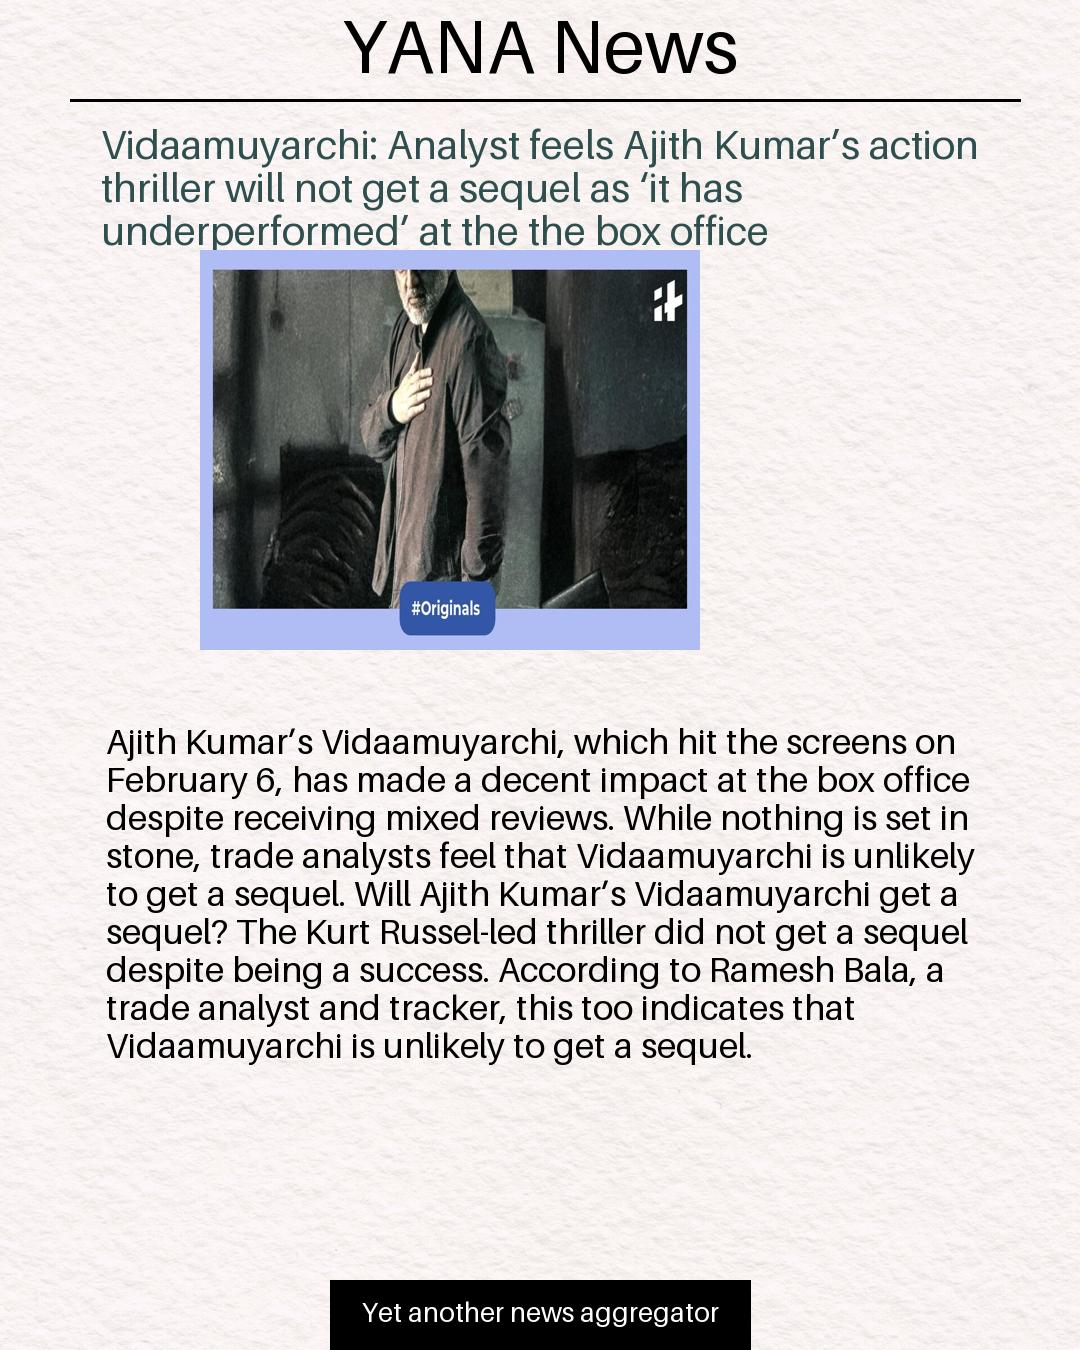

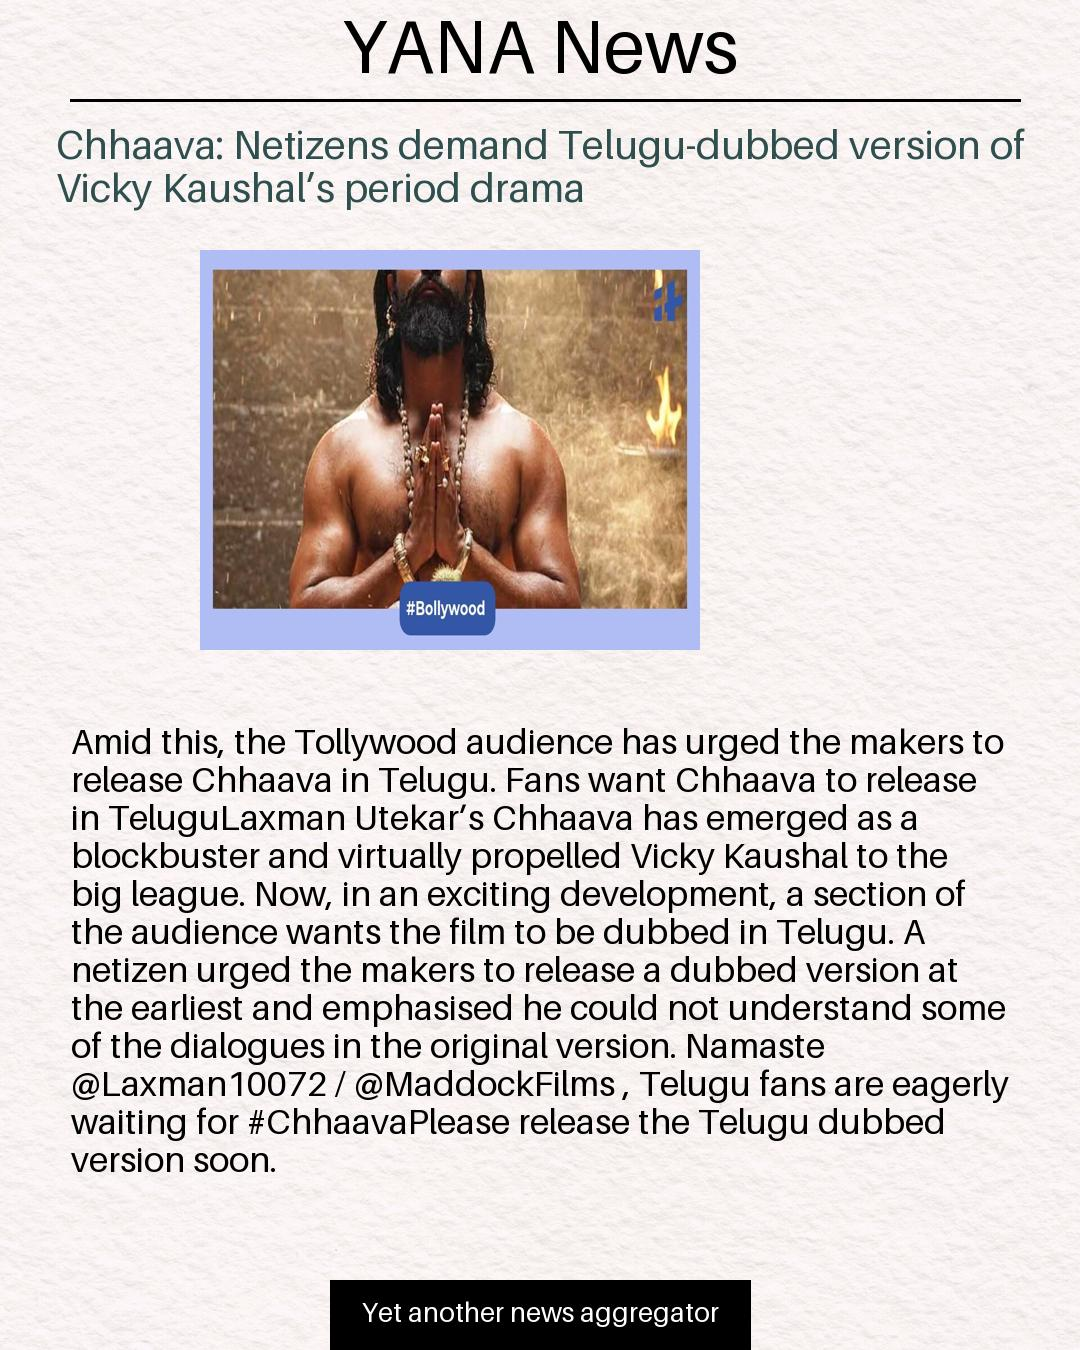

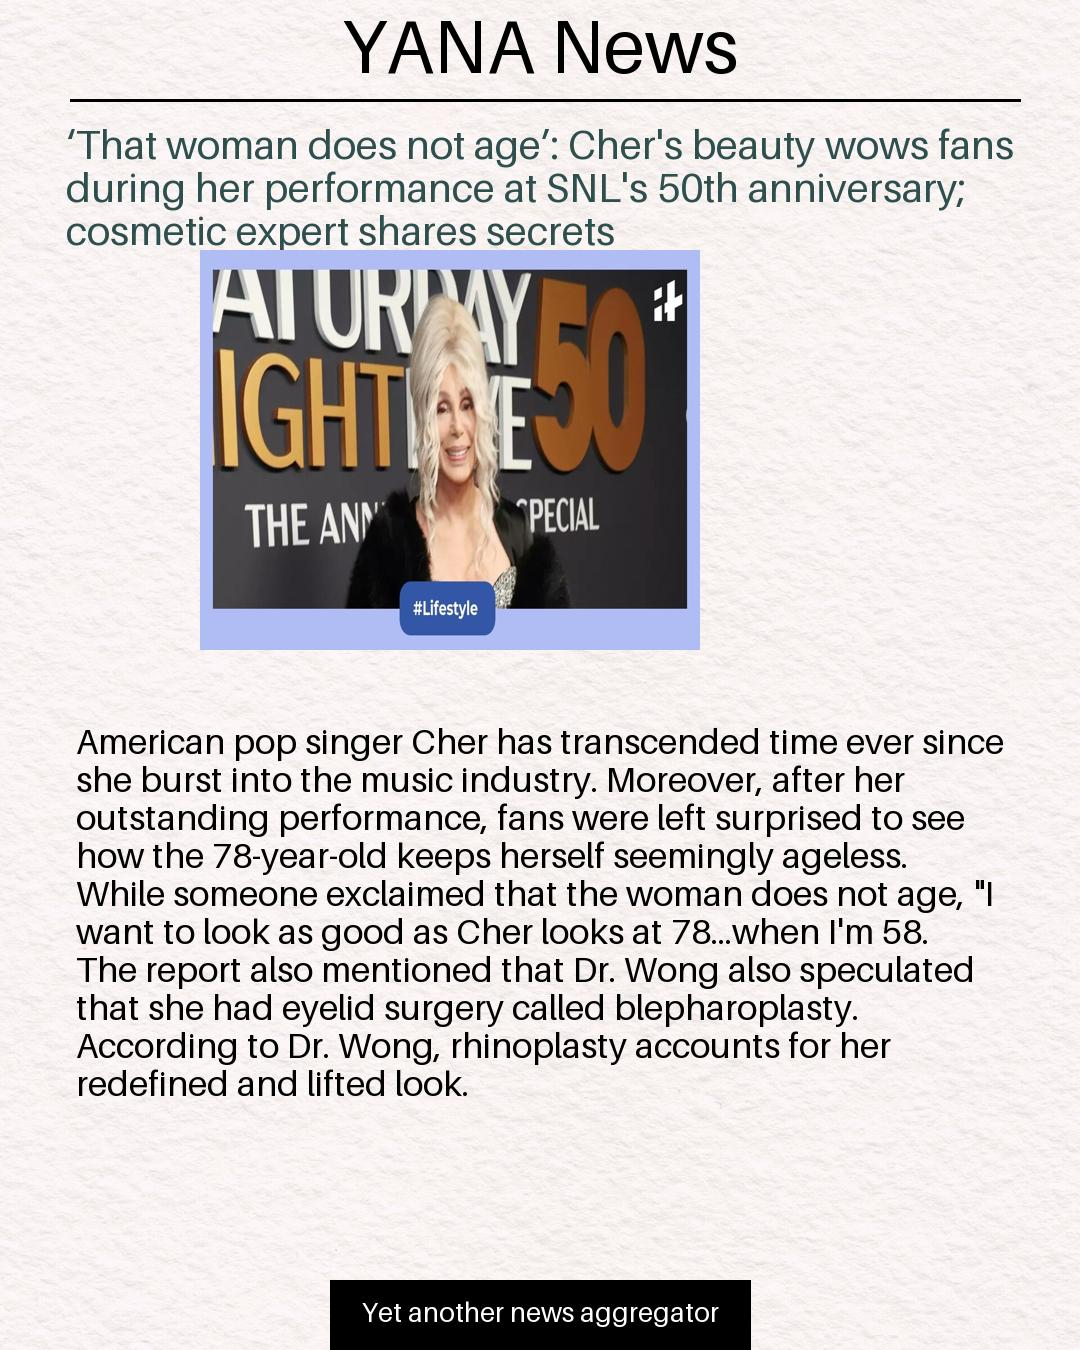

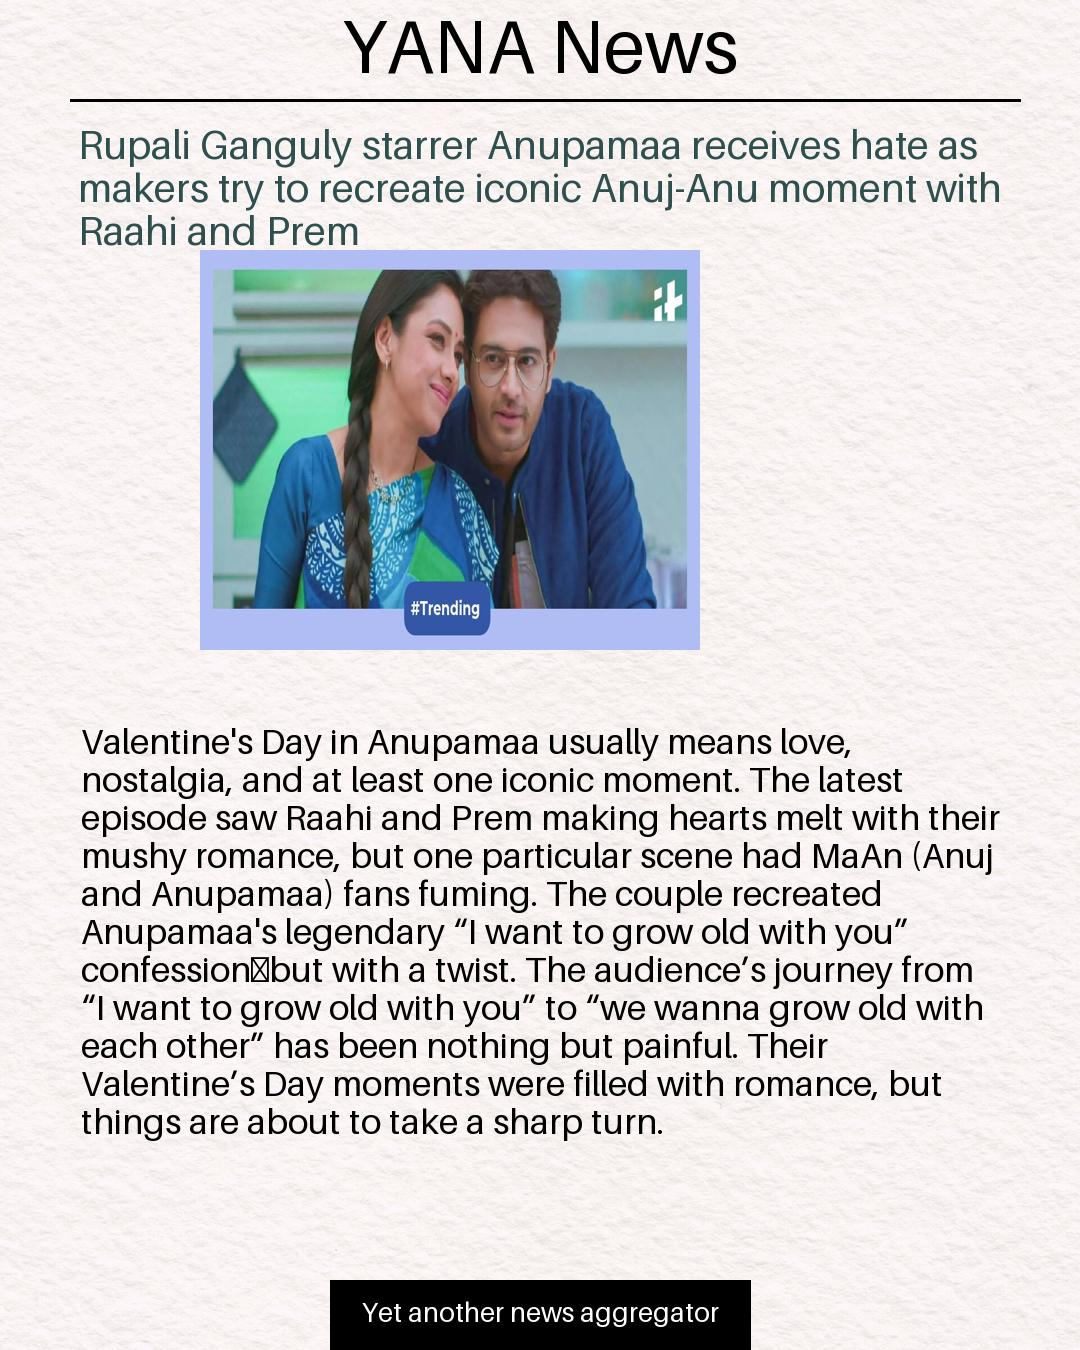

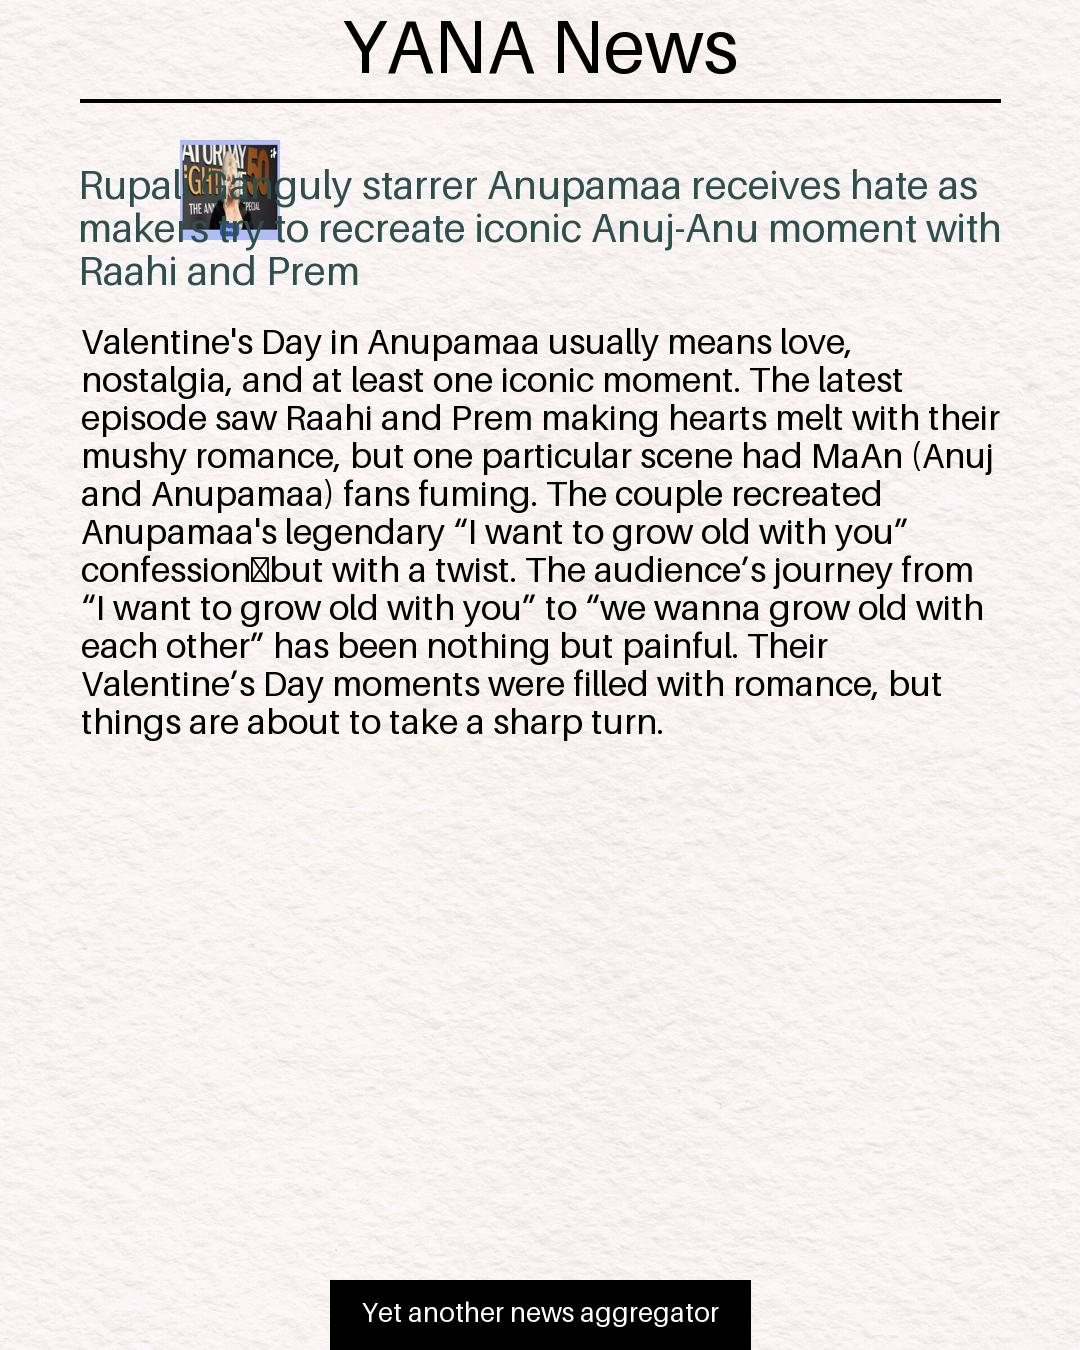

In [141]:
from PIL import Image, ImageFont, ImageDraw
import textwrap

# Assuming 'df', 'CURRENT_DATE', and 'ENV' are defined

df = current_df

my_image = Image.open("/content/YANA/news_bg.jpg").resize((1080, 1350))
image_directory = '/content/YANA/dev/images/2025-02-18'


# Default Font Sizes
FONT_SIZES = {
    "title": 40,
    "date": 22,
    "metadata": 22,
    "header": 75,
    "footer": 27,
    "summary": 35
}


for index, row in df.iterrows():
    try:
        # index = index+1
        modified_image = my_image.copy()
        x, y = modified_image.size
        draw = ImageDraw.Draw(modified_image)

        article_title = row['title']  # Get article title
        image_filename = article_title + '.jpg'  # Assuming images are named after titles with .png extension
        image_path = os.path.join(image_directory, image_filename)



        # Load Default Fonts (no paths specified)
        fonts = {}
        for name, size in FONT_SIZES.items():
            fonts[name] = ImageFont.load_default(size)

        # Header
        header_text = 'YANA News'  # Changed 'hdr' to 'header_text' for clarity
        bbox_header = draw.textbbox((0, 0), header_text, font=fonts["header"])  # Changed "pinaka" to "header"
        textwidth_header = bbox_header[2] - bbox_header[0]
        draw.text((x / 2 - textwidth_header / 2, 0), header_text, fill='black', font=fonts["header"])  # Changed "pinaka" to "header"
        draw.line([(70, 100), (1020, 100)], fill='black', width=3)


        # title
        # title = textwrap.fill(text=str(df['title'][index]), width=50)
        title = textwrap.fill(text=str(df['llm_headline'][index]), width=50)
        bbox_title = draw.textbbox((0, 0), title, font=fonts["title"])
        textwidth_title = bbox_title[2] - bbox_title[0]
        draw.text((x / 2 - textwidth_title / 2, 120), title, fill='darkslategray', font=fonts["title"])

        # article image
        article_image = Image.open(image_path)

        new_width = 500  # Desired width in pixels
        new_height = 400  # Desired height in pixels
        article_image = article_image.resize((new_width, new_height))

        # Define position to paste (you'll need to adjust this)
        x_position = 200
        y_position = 250 #+ index * 220  # Adjust spacing as needed

        modified_image.paste(article_image, (x_position, y_position))

        # Summary
        # summary = textwrap.fill(text=str(df['summary'][index]), width=57)
        summary = textwrap.fill(text=str(df['llm_news'][index]), width=57)
        bbox_summary = draw.textbbox((0, 0), summary, font=fonts["summary"])
        textwidth_summary = bbox_summary[2] - bbox_summary[0]
        draw.text((x / 2 - textwidth_summary / 2, 720), summary, fill='black', font=fonts["summary"])

        # Footer
        draw.rectangle((330, 1280, 750, 1380), fill='black', width=5)

        yana = 'Yet another news aggregator'
        bbox_yana = draw.textbbox((0, 0), yana, font=fonts["footer"])
        textwidth_yana = bbox_yana[2] - bbox_yana[0]
        draw.text((x / 2 - textwidth_yana / 2, 1295), yana, fill='white', font=fonts["footer"])

        # write images
        modified_image.save(f"/content/YANA/{ENV}/news_images/{CURRENT_DATE}/result_{CURRENT_DATE}_{index}.jpg")

    except KeyError as e:
        print(f"Error: DataFrame column not found: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Display each image
modified_image.show()
from IPython.display import Image, display
# num = 1
for num in range(5):
    display(Image(filename=f'/content/YANA/{ENV}/news_images/{CURRENT_DATE}/result_{CURRENT_DATE}_{num}.jpg'))

In [36]:
current_df

,publish_date,title,summary,desc,llm_headline,llm_news
0,2025-02-18,You Season 5: Here's what to expect in the fin...,You Season 5 OTT release date: The highly anti...,You Season 5 OTT release date: The highly anti...,Loving Love: Kunal Roy Kapur Celebrates His Ne...,"With his new film, Kunal Roy Kapur has taken a..."
1,2025-02-18,Yeh Jawaani Hai Deewani sequel not needed? Kun...,One of those movies that people never grow wea...,One of those movies that people never grow wea...,' and the article with '@@'.\n\nI'll structure...,'.\n\nI'll structure it as an inverted pyramid...
